# 수강생분의 이름, 학번을 반영해주세요.

In [1]:
id = '20171601'
name = '최영창'
print(id, name)

20171601 최영창


## 필요 모듈 설치

In [2]:
#!pip uninstall -y segmentation-models-pytorch
!pip install pretrainedmodels==0.7.4
!pip install efficientnet_pytorch==0.6.3
!pip install timm==0.4.12
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=b28ad74d2a9b78731d026fc0051915dbdb6eb36334e07eb0359d1d65b58e19b5
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=c3bd15dc636dda448b89654e81622a29c2719d1901c6e69111f39a5d884ad312
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built efficientnet-pytorch
     |████████████████████████████████| 376 kB 5.2 MB/s 
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-37q4_zw3
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-37q4_zw3
     |████████████████████████████████| 47.6 MB 1.6 MB/s 
  Created whe

## 구글 드라이브 연동

In [3]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pprint

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
workspace_path = '/gdrive/MyDrive/Colab Notebooks/CV/SIA'
segmentation_path = os.path.join(workspace_path, 'segmentation_models')

In [6]:
import sys
sys.path.append(segmentation_path)  # segmentation 소스코드 경로 설정

In [7]:
LV2_train_path=os.path.join(workspace_path, 'LV2_training_set')

x_train_dir = os.path.join(LV2_train_path, 'images')
y_building_train_dir = os.path.join(LV2_train_path, 'labels/building')
y_road_train_dir = os.path.join(LV2_train_path, 'labels/road')

LV2_valid_path=os.path.join(workspace_path, 'LV2_validation_set')

x_valid_dir = os.path.join(LV2_valid_path, 'images')
y_building_valid_dir = os.path.join(LV2_valid_path, 'labels/building')
y_road_valid_dir = os.path.join(LV2_valid_path, 'labels/road')

combine_train_label=os.path.join(LV2_train_path,'labels/combine')
combine_valid_label=os.path.join(LV2_valid_path,'labels/combine')

In [8]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## 데이터로더 정의

In [9]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [10]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['building', 'road']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        #self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.class_values=[200, 255]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

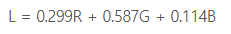

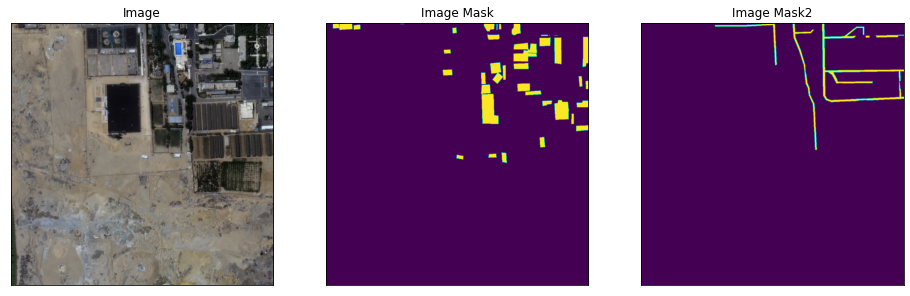

In [11]:
# Lets look at data we have

dataset = Dataset(x_train_dir, combine_train_label, classes=['building','road'])

image, mask = dataset[3] # get some sample
visualize(
    image=image, 
    image_mask=mask[...,0].squeeze(),
    image_mask2=mask[...,1].squeeze(),
)

## 데이터증대

In [12]:
import albumentations as albu

In [13]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:262: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:385: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1805: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:232: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

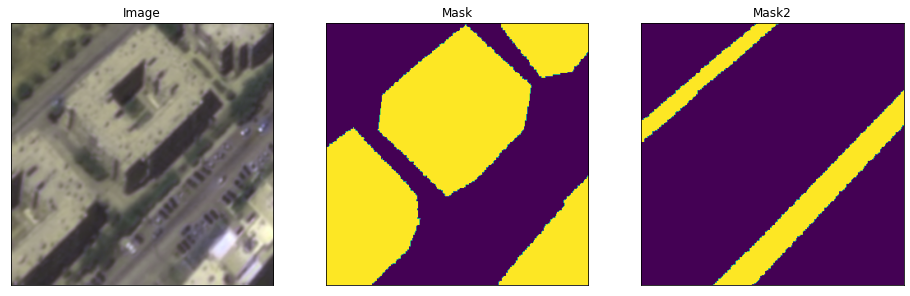

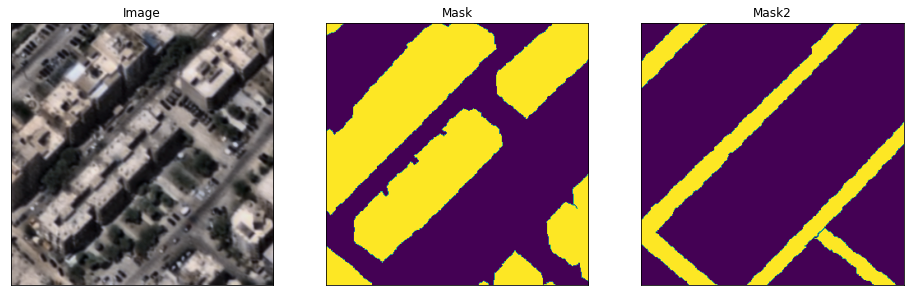

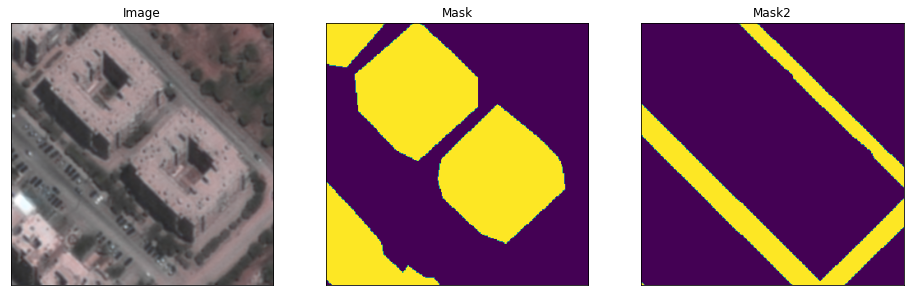

In [14]:
augmented_dataset = Dataset(
    x_train_dir, 
    combine_train_label,
    augmentation=get_training_augmentation(), 
    classes=['building', 'road'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(
        image=image,
        mask=mask[...,0].squeeze(),
        mask2=mask[...,1].squeeze()
    )

## 모델 불러오기 및 검증

In [15]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [16]:
CLASSES = ['building', 'road']
DEVICE = 'cuda'

save_dir = os.path.join(workspace_path, 'ckpt')
os.makedirs(save_dir, exist_ok=True)

model = torch.load(os.path.join(save_dir, 'best_model.pth'))

# create segmentation model with pretrained encoder
preprocessing_fn = smp.encoders.get_preprocessing_fn('se_resnext101_32x4d', 'imagenet')

In [17]:
valid_dataset = Dataset(
    x_valid_dir, 
    combine_valid_label, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=1)

In [18]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [19]:
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
import time
max_score = 0
iou_score = []
dice_loss = []
fps_time = []

for i in range(0, 3):
    print('\nEpoch: {}'.format(i))

    begin = time.time()
    valid_logs = valid_epoch.run(valid_loader)
    end = time.time()
    fps = (end-begin)/142
    print(fps)
    fps_time.append(fps)

    iou_score.append(valid_logs['iou_score'])
    dice_loss.append(valid_logs['dice_loss'])
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        
    if i == 20:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 142/142 [05:02<00:00,  2.13s/it, dice_loss - 0.2691, iou_score - 0.6311]
2.128331832482781

Epoch: 1
valid: 100%|██████████| 142/142 [04:51<00:00,  2.05s/it, dice_loss - 0.2691, iou_score - 0.6311]
2.0509042118636653

Epoch: 2
valid: 100%|██████████| 142/142 [04:51<00:00,  2.05s/it, dice_loss - 0.2691, iou_score - 0.6311]
2.050671206393712


## 이미지 시각화

In [ ]:
best_model = model

In [ ]:
valid_dataset_vis = Dataset(
    x_valid_dir, combine_valid_label, 
    classes=CLASSES,
)

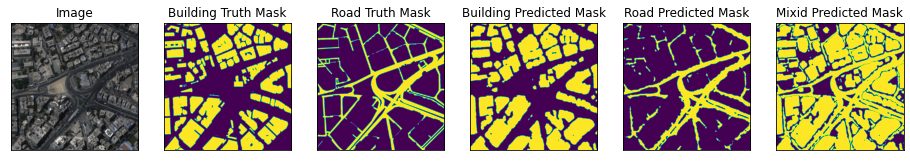

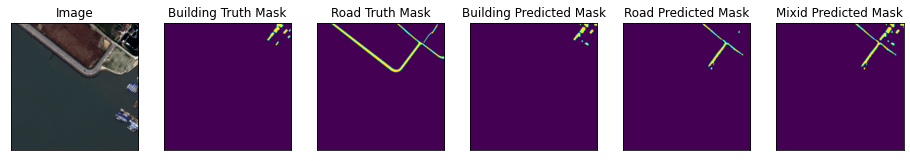

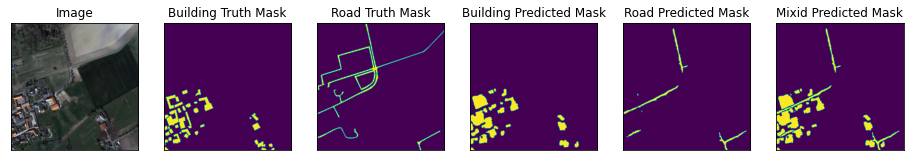

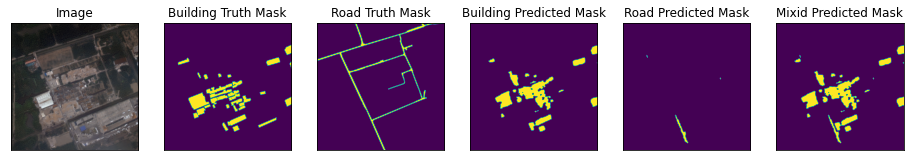

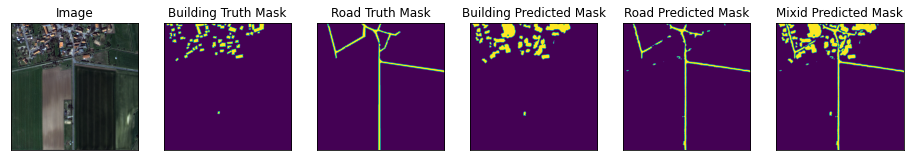

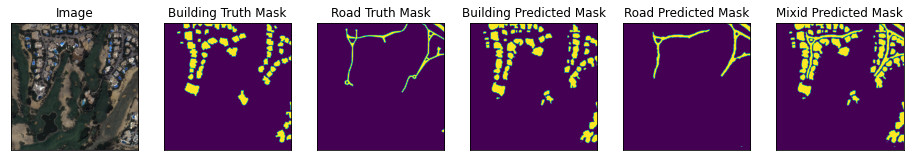

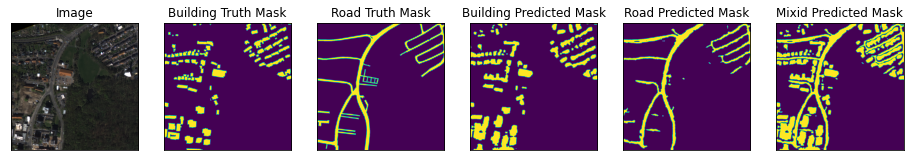

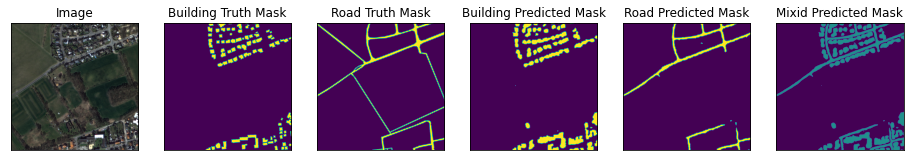

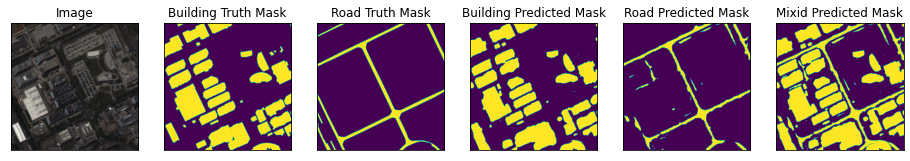

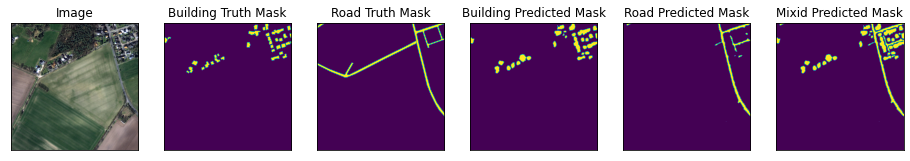

In [ ]:
for i in range(5):
    n = np.random.choice(len(valid_dataset))
    
    image_vis = valid_dataset_vis[n][0].astype('uint8')
    image, gt_mask = valid_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    img3 = pr_mask[0,...].squeeze() + pr_mask[1,...].squeeze()
        
    visualize(
        image=image_vis, 
        building_truth_mask=gt_mask[0,...].squeeze(), 
        road_truth_mask=gt_mask[1,...].squeeze(),
        building_predicted_mask=pr_mask[0,...].squeeze(),
        road_predicted_mask=pr_mask[1,...].squeeze(),
        mixid_predicted_mask= img3,
    )